# Ujjwal Chowdhury
## Asignment 4

#### Assignmemt on regularised regression

##### Select a  dataset from the UCI dataset on regression (exclude categorical ovaribales for now). First inspect the predictors for multicolinearity and select  a subset which is linearly independent. Next find solution of linear regression model using normal equations  and sequential gradient descent (Widrow Hoff ). Next fit a LASSO and Ridge model using scipy.optimize library. Plot the solution pathh for different values of α using "lassopath" and "ridgepath" libraries of scipy. Compare the three models in terms of the solution obtained, prediction accuracy etc. Interpret the Lasso and Ridge solutions in terms of selection and shrinkage. Upload two files - one code and one pdf with the brief report.

## 1. Importing libraries 

In [60]:
import numpy as np
import pandas as pd
# Needed for plotting
import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns 

# Needed for generating training and testing datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso , Ridge ,lasso_path , ridge_regression ,LassoLars ,lars_path
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from scipy.optimize import minimize
import matplotlib.pyplot as plt

from matplotlib import cm
%matplotlib inline
from sklearn import linear_model

## 2. Setting up working directory

In [2]:
%cd C:/Users/Ujjwa/OneDrive/Desktop/BDA/Semester 2/CDS/CDS Assignment/Assignment 4/superconduct/

C:\Users\Ujjwa\OneDrive\Desktop\BDA\Semester 2\CDS\CDS Assignment\Assignment 4\superconduct


## 3. Reading the csv file

In [3]:
data = pd.read_csv('train.csv')

## 4. Summary of the data


### 4.1 Information about each Attributes

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

### 4.2 Filtering the data

#### We will use only the weighted columns

In [4]:
filter_col = [col for col in data if col.startswith('w')]
df = data[filter_col]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   wtd_mean_atomic_mass             21263 non-null  float64
 1   wtd_gmean_atomic_mass            21263 non-null  float64
 2   wtd_entropy_atomic_mass          21263 non-null  float64
 3   wtd_range_atomic_mass            21263 non-null  float64
 4   wtd_std_atomic_mass              21263 non-null  float64
 5   wtd_mean_fie                     21263 non-null  float64
 6   wtd_gmean_fie                    21263 non-null  float64
 7   wtd_entropy_fie                  21263 non-null  float64
 8   wtd_range_fie                    21263 non-null  float64
 9   wtd_std_fie                      21263 non-null  float64
 10  wtd_mean_atomic_radius           21263 non-null  float64
 11  wtd_gmean_atomic_radius          21263 non-null  float64
 12  wtd_entropy_atomic

### 4.3 Counting NA values per column

In [6]:
df.isna().sum()

wtd_mean_atomic_mass               0
wtd_gmean_atomic_mass              0
wtd_entropy_atomic_mass            0
wtd_range_atomic_mass              0
wtd_std_atomic_mass                0
wtd_mean_fie                       0
wtd_gmean_fie                      0
wtd_entropy_fie                    0
wtd_range_fie                      0
wtd_std_fie                        0
wtd_mean_atomic_radius             0
wtd_gmean_atomic_radius            0
wtd_entropy_atomic_radius          0
wtd_range_atomic_radius            0
wtd_std_atomic_radius              0
wtd_mean_Density                   0
wtd_gmean_Density                  0
wtd_entropy_Density                0
wtd_range_Density                  0
wtd_std_Density                    0
wtd_mean_ElectronAffinity          0
wtd_gmean_ElectronAffinity         0
wtd_entropy_ElectronAffinity       0
wtd_range_ElectronAffinity         0
wtd_std_ElectronAffinity           0
wtd_mean_FusionHeat                0
wtd_gmean_FusionHeat               0
w

### 4.4 Cheaking the correlation between each columns in the data frame

##### (Using heat map to check visually)

Text(0.5, 1.0, 'Correlations')

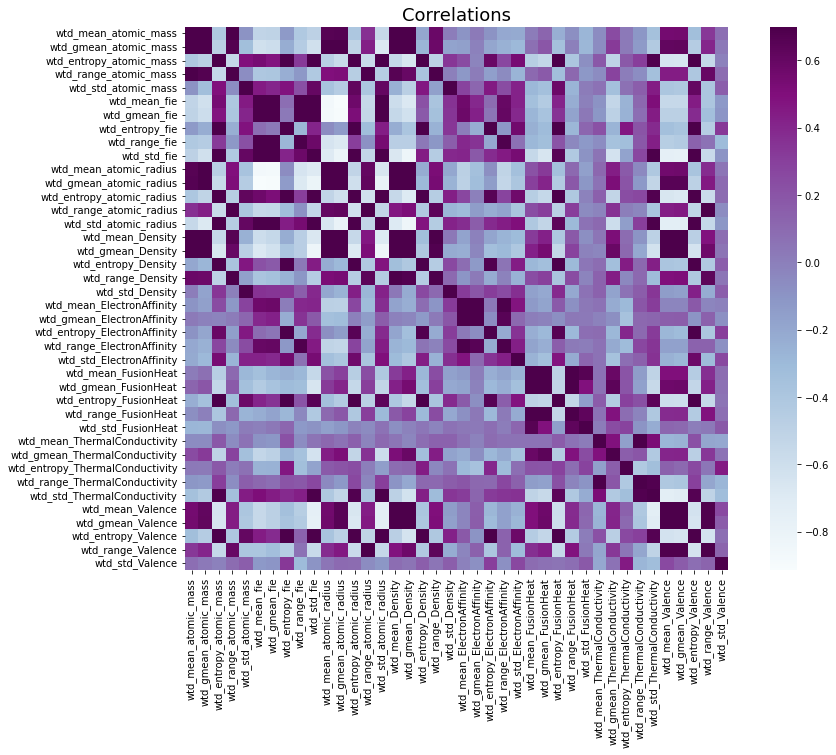

In [7]:
corr = df.corr() # calculationg the correlation dataframe
plt.subplots(figsize=(15,10)) # figure size 
ax = sns.heatmap(corr, cmap="BuPu", vmax=0.7, square=True) # for plotting the heat map [add annot=True in side () to see the numerical values]
ax.set_title("Correlations", fontsize = 18)

### 4.5 Cheaking multicollinearity using VIF (Variance Inflation Factor)

##### Variance inflation factor measures how much the behavior (variance) of an independent variable is influenced, or inflated, by its interaction/correlation with the other independent variables. Variance inflation factors allow a quick measure of how much a variable is contributing to the standard error in the regression.

##### A rule of thumb for interpreting the variance inflation factor:

##### 1 = not correlated.
##### Between 1 and 5 = moderately correlated.
##### Greater than 5 = highly correlated.

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
{df.columns[i]: variance_inflation_factor(df.values, i) for i in range(1, df.shape[1])}

{'wtd_gmean_atomic_mass': 902.8496705725279,
 'wtd_entropy_atomic_mass': 634.4497988095854,
 'wtd_range_atomic_mass': 45.04433831706211,
 'wtd_std_atomic_mass': 78.69732882882464,
 'wtd_mean_fie': 102356.30749043249,
 'wtd_gmean_fie': 92320.17602193289,
 'wtd_entropy_fie': 617.710028517159,
 'wtd_range_fie': 184.774230802792,
 'wtd_std_fie': 400.26844143198593,
 'wtd_mean_atomic_radius': 17866.423256801103,
 'wtd_gmean_atomic_radius': 14799.360104517857,
 'wtd_entropy_atomic_radius': 1120.0735500722842,
 'wtd_range_atomic_radius': 44.444574171285495,
 'wtd_std_atomic_radius': 237.77270633400974,
 'wtd_mean_Density': 412.8476979112092,
 'wtd_gmean_Density': 212.46924415117138,
 'wtd_entropy_Density': 153.81603700748235,
 'wtd_range_Density': 39.538831878585846,
 'wtd_std_Density': 33.73796973233668,
 'wtd_mean_ElectronAffinity': 600.9028672914558,
 'wtd_gmean_ElectronAffinity': 310.00002136543236,
 'wtd_entropy_ElectronAffinity': 112.61531474184275,
 'wtd_range_ElectronAffinity': 77.500

In [5]:
# Copying the dataset
df_c = pd.DataFrame(df.copy())

### 4.6 Creating a function that delete highly correlated columns

In [49]:
def correlation_select(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold or corr_matrix.iloc[i, j] <= -threshold ) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    print(dataset.info())

### 4.7 Using the function to remove highly correlated columns

In [50]:
correlation_select(df_c,0.6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   wtd_mean_atomic_mass             21263 non-null  float64
 1   wtd_entropy_atomic_mass          21263 non-null  float64
 2   wtd_std_atomic_mass              21263 non-null  float64
 3   wtd_mean_fie                     21263 non-null  float64
 4   wtd_range_atomic_radius          21263 non-null  float64
 5   wtd_mean_ElectronAffinity        21263 non-null  float64
 6   wtd_entropy_ElectronAffinity     21263 non-null  float64
 7   wtd_std_ElectronAffinity         21263 non-null  float64
 8   wtd_mean_FusionHeat              21263 non-null  float64
 9   wtd_mean_ThermalConductivity     21263 non-null  float64
 10  wtd_gmean_ThermalConductivity    21263 non-null  float64
 11  wtd_entropy_ThermalConductivity  21263 non-null  float64
 12  wtd_std_Valence   

In [11]:
#Selected columns as features
df_c.columns

Index(['wtd_mean_atomic_mass', 'wtd_entropy_atomic_mass',
       'wtd_std_atomic_mass', 'wtd_mean_fie', 'wtd_range_atomic_radius',
       'wtd_mean_ElectronAffinity', 'wtd_entropy_ElectronAffinity',
       'wtd_std_ElectronAffinity', 'wtd_mean_FusionHeat',
       'wtd_mean_ThermalConductivity', 'wtd_gmean_ThermalConductivity',
       'wtd_entropy_ThermalConductivity', 'wtd_mean_Valence',
       'wtd_std_Valence'],
      dtype='object')

Text(0.5, 1.0, 'Correlations')

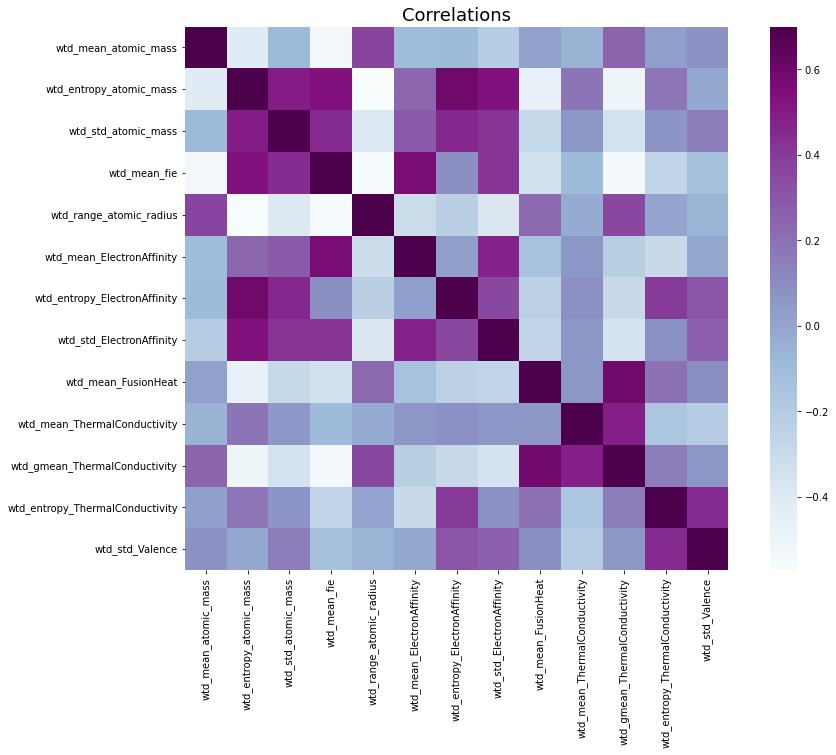

In [51]:
corr = df_c.corr() # calculationg the correlation dataframe
plt.subplots(figsize=(15,10)) # figure size 
ax = sns.heatmap(corr, cmap="BuPu", vmax=0.7, square=True) # for plotting the heat map [add annot=True in side () to see the numerical values]
ax.set_title("Correlations", fontsize = 18)

## 5. Seperating the dataset

### 5.1 Subsetting the dataframe into feature and label

In [52]:
X = np.array(df_c)
y = np.array(data['critical_temp'])

### 5.2 Spliting the dataset into training and testing

In [53]:
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.1, shuffle=True)

# 6. Implementing OLS

In [54]:
res = sm.OLS(data['critical_temp'], df_c).fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:          critical_temp   R-squared (uncentered):                   0.826
Model:                            OLS   Adj. R-squared (uncentered):              0.826
Method:                 Least Squares   F-statistic:                              7740.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):                        0.00
Time:                        19:58:43   Log-Likelihood:                         -94162.
No. Observations:               21263   AIC:                                  1.883e+05
Df Residuals:                   21250   BIC:                                  1.885e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [55]:
# OLS Coefficient estimates

OLS_Coff=pd.DataFrame(res.params)

# 7. Implementing Gradient Descent

## 7.1 Creating function for implementing Gradient Descent

In [12]:
class Regressor():
    def __init__(self, learning_rate=0.01, tol=0.01, seed=None,normalize=False):
        self.W = None
        self.b = None
        self.__lr = learning_rate
        self.__tol = tol
        self.__length = None
        self.__normalize = normalize
        self.__m = None
        self.__costs = []
        self.__iterations = []
        self.__ws = []
        self.__bs = []
        np.random.seed(seed if seed is not None else np.random.randint(100))

    def __initialize_weights_and_bias(self):
        self.W = np.random.randn(self.__length) #(n,1)
        self.b = 0
        self.__ws.append(self.W)
        self.__bs.append(self.b)

    def __computeCost(self,h,Y):
        loss = np.square(h-Y)
        cost = np.sum(loss)/(2*self.__m)
        return cost

    def __optimize(self,X,Y):
        h = np.dot(X,self.W)+self.b
        dW = np.dot( X.T, (h-Y) ) / self.__m
        db = np.sum( h-Y )  / self.__m
        self.W = self.W - self.__lr*dW
        self.b = self.b - self.__lr*db

    def __normalizeX(self,X):return (X-self.__mean) / (self.__std)

    def fit(self, X, y, verbose=True):
        if self.__normalize:
            self.__mean, self.__std = X.mean(axis=0), X.std(axis=0)
            X = self.__normalizeX(X)
        self.__m,self.__length = X.shape
        self.__initialize_weights_and_bias()
        last_cost,i = float('inf'),0
        while True:
            h = np.dot(X,self.W)+self.b
            cost = self.__computeCost(h,y)
            if verbose: print(f"Iteration: {i}, Cost: {cost:.3f}")
            self.__optimize(X,y)
            if last_cost-cost < self.__tol: break
            else: last_cost,i = cost,i+1
            self.__costs.append(cost)
            self.__iterations.append(i)

    def predict(self,X):

        if self.__normalize: X = self.__normalizeX(X)
        return np.dot(X,self.W)+self.b
    
    def seq_fit(self, X, y, verbose=True):
        if self.__normalize:
            self.__mean, self.__std = X.mean(axis=0), X.std(axis=0)
            X = self.__normalizeX(X)
        self.__m,self.__length = X.shape
        self.__initialize_weights_and_bias()
        last_cost,j = float('inf'),0
        while True:
            cost=0
            for i in range(len(X)):
                h = np.dot(X[i],self.W)+self.b
                cost += self.__computeCost(h,y[i])
                self.__optimize(X[i],y[i])

            if verbose: print(f"Iteration: {j}, Cost: {cost:.3f}")
            if last_cost-cost < self.__tol: break
            else: last_cost,j = cost,j+1
            self.__costs.append(cost)
            self.__iterations.append(j)     

    def plot(self,figsize=(7,5)):
        plt.figure(figsize=figsize)
        plt.plot(self.__iterations,self.__costs)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title("Iterations vs Cost")
        plt.show()

    def score(self,X,y):
        return 1-(np.sum(((y-self.predict(X))**2))/np.sum((y-np.mean(y))**2))
  

## 7.2 Batch Gradient Descent

X_train:(14884, 14)
y_train:(14884,)
Iteration: 0, Cost: 1249.598
Iteration: 1, Cost: 1209.501
Iteration: 2, Cost: 1171.979
Iteration: 3, Cost: 1136.821
Iteration: 4, Cost: 1103.834
Iteration: 5, Cost: 1072.843
Iteration: 6, Cost: 1043.688
Iteration: 7, Cost: 1016.222
Iteration: 8, Cost: 990.312
Iteration: 9, Cost: 965.837
Iteration: 10, Cost: 942.686
Iteration: 11, Cost: 920.758
Iteration: 12, Cost: 899.960
Iteration: 13, Cost: 880.209
Iteration: 14, Cost: 861.426
Iteration: 15, Cost: 843.541
Iteration: 16, Cost: 826.491
Iteration: 17, Cost: 810.216
Iteration: 18, Cost: 794.661
Iteration: 19, Cost: 779.779
Iteration: 20, Cost: 765.522
Iteration: 21, Cost: 751.851
Iteration: 22, Cost: 738.726
Iteration: 23, Cost: 726.113
Iteration: 24, Cost: 713.979
Iteration: 25, Cost: 702.296
Iteration: 26, Cost: 691.036
Iteration: 27, Cost: 680.174
Iteration: 28, Cost: 669.687
Iteration: 29, Cost: 659.554
Iteration: 30, Cost: 649.756
Iteration: 31, Cost: 640.273
Iteration: 32, Cost: 631.091
Iteratio

Iteration: 439, Cost: 222.671
Iteration: 440, Cost: 222.632
Iteration: 441, Cost: 222.592
Iteration: 442, Cost: 222.553
Iteration: 443, Cost: 222.514
Iteration: 444, Cost: 222.475
Iteration: 445, Cost: 222.436
Iteration: 446, Cost: 222.398
Iteration: 447, Cost: 222.359
Iteration: 448, Cost: 222.321
Iteration: 449, Cost: 222.283
Iteration: 450, Cost: 222.245
Iteration: 451, Cost: 222.207
Iteration: 452, Cost: 222.169
Iteration: 453, Cost: 222.131
Iteration: 454, Cost: 222.094
Iteration: 455, Cost: 222.056
Iteration: 456, Cost: 222.019
Iteration: 457, Cost: 221.982
Iteration: 458, Cost: 221.945
Iteration: 459, Cost: 221.908
Iteration: 460, Cost: 221.872
Iteration: 461, Cost: 221.835
Iteration: 462, Cost: 221.799
Iteration: 463, Cost: 221.762
Iteration: 464, Cost: 221.726
Iteration: 465, Cost: 221.690
Iteration: 466, Cost: 221.654
Iteration: 467, Cost: 221.619
Iteration: 468, Cost: 221.583
Iteration: 469, Cost: 221.547
Iteration: 470, Cost: 221.512
Iteration: 471, Cost: 221.477
Iteration:

Iteration: 867, Cost: 213.049
Iteration: 868, Cost: 213.037
Iteration: 869, Cost: 213.024
Iteration: 870, Cost: 213.011
Iteration: 871, Cost: 212.999
Iteration: 872, Cost: 212.986
Iteration: 873, Cost: 212.973
Iteration: 874, Cost: 212.961
Iteration: 875, Cost: 212.948
Iteration: 876, Cost: 212.936
Iteration: 877, Cost: 212.923
Iteration: 878, Cost: 212.911
Iteration: 879, Cost: 212.898
Iteration: 880, Cost: 212.886
Iteration: 881, Cost: 212.873
Iteration: 882, Cost: 212.861
Iteration: 883, Cost: 212.849
Iteration: 884, Cost: 212.836
Iteration: 885, Cost: 212.824
Iteration: 886, Cost: 212.812
Iteration: 887, Cost: 212.800
Iteration: 888, Cost: 212.787
Iteration: 889, Cost: 212.775
Iteration: 890, Cost: 212.763
Iteration: 891, Cost: 212.751
Iteration: 892, Cost: 212.739
Iteration: 893, Cost: 212.727
Iteration: 894, Cost: 212.715
Iteration: 895, Cost: 212.703
Iteration: 896, Cost: 212.691
Iteration: 897, Cost: 212.679
Iteration: 898, Cost: 212.667
Iteration: 899, Cost: 212.655
Iteration:

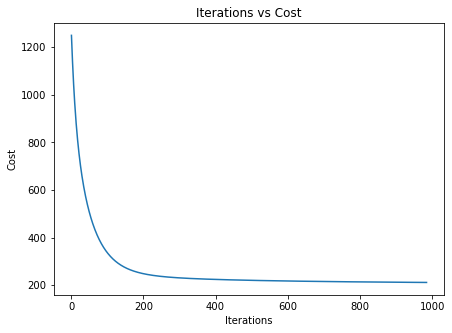

In [14]:
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")

batch_regressor = Regressor(normalize=True)
batch_regressor.fit(X_train,y_train)

train_score = r2_score(batch_regressor.predict(X_train),y_train)
test_score = r2_score(batch_regressor.predict(X_test),y_test)

print("Train Score:", train_score)
print("Test Score: ",test_score)
batch_regressor.plot()

## 7.3 Sequential Gradient Descent

X_train:(14884, 14)
y_train:(14884,)
Iteration: 0, Cost: 1168.856
Iteration: 1, Cost: 1136.562
Iteration: 2, Cost: 1106.091
Iteration: 3, Cost: 1077.303
Iteration: 4, Cost: 1050.072
Iteration: 5, Cost: 1024.280
Iteration: 6, Cost: 999.820
Iteration: 7, Cost: 976.595
Iteration: 8, Cost: 954.516
Iteration: 9, Cost: 933.499
Iteration: 10, Cost: 913.471
Iteration: 11, Cost: 894.361
Iteration: 12, Cost: 876.108
Iteration: 13, Cost: 858.653
Iteration: 14, Cost: 841.942
Iteration: 15, Cost: 825.927
Iteration: 16, Cost: 810.563
Iteration: 17, Cost: 795.809
Iteration: 18, Cost: 781.627
Iteration: 19, Cost: 767.981
Iteration: 20, Cost: 754.840
Iteration: 21, Cost: 742.173
Iteration: 22, Cost: 729.954
Iteration: 23, Cost: 718.157
Iteration: 24, Cost: 706.759
Iteration: 25, Cost: 695.737
Iteration: 26, Cost: 685.073
Iteration: 27, Cost: 674.747
Iteration: 28, Cost: 664.743
Iteration: 29, Cost: 655.044
Iteration: 30, Cost: 645.636
Iteration: 31, Cost: 636.505
Iteration: 32, Cost: 627.638
Iteration:

Iteration: 276, Cost: 233.720
Iteration: 277, Cost: 233.604
Iteration: 278, Cost: 233.489
Iteration: 279, Cost: 233.375
Iteration: 280, Cost: 233.263
Iteration: 281, Cost: 233.152
Iteration: 282, Cost: 233.041
Iteration: 283, Cost: 232.932
Iteration: 284, Cost: 232.824
Iteration: 285, Cost: 232.717
Iteration: 286, Cost: 232.612
Iteration: 287, Cost: 232.507
Iteration: 288, Cost: 232.403
Iteration: 289, Cost: 232.300
Iteration: 290, Cost: 232.198
Iteration: 291, Cost: 232.098
Iteration: 292, Cost: 231.998
Iteration: 293, Cost: 231.899
Iteration: 294, Cost: 231.801
Iteration: 295, Cost: 231.704
Iteration: 296, Cost: 231.608
Iteration: 297, Cost: 231.512
Iteration: 298, Cost: 231.418
Iteration: 299, Cost: 231.324
Iteration: 300, Cost: 231.232
Iteration: 301, Cost: 231.140
Iteration: 302, Cost: 231.049
Iteration: 303, Cost: 230.958
Iteration: 304, Cost: 230.869
Iteration: 305, Cost: 230.780
Iteration: 306, Cost: 230.692
Iteration: 307, Cost: 230.605
Iteration: 308, Cost: 230.519
Iteration:

Iteration: 550, Cost: 219.111
Iteration: 551, Cost: 219.082
Iteration: 552, Cost: 219.053
Iteration: 553, Cost: 219.025
Iteration: 554, Cost: 218.996
Iteration: 555, Cost: 218.968
Iteration: 556, Cost: 218.939
Iteration: 557, Cost: 218.911
Iteration: 558, Cost: 218.883
Iteration: 559, Cost: 218.855
Iteration: 560, Cost: 218.827
Iteration: 561, Cost: 218.799
Iteration: 562, Cost: 218.771
Iteration: 563, Cost: 218.743
Iteration: 564, Cost: 218.715
Iteration: 565, Cost: 218.688
Iteration: 566, Cost: 218.660
Iteration: 567, Cost: 218.633
Iteration: 568, Cost: 218.605
Iteration: 569, Cost: 218.578
Iteration: 570, Cost: 218.551
Iteration: 571, Cost: 218.523
Iteration: 572, Cost: 218.496
Iteration: 573, Cost: 218.469
Iteration: 574, Cost: 218.442
Iteration: 575, Cost: 218.415
Iteration: 576, Cost: 218.389
Iteration: 577, Cost: 218.362
Iteration: 578, Cost: 218.335
Iteration: 579, Cost: 218.309
Iteration: 580, Cost: 218.282
Iteration: 581, Cost: 218.256
Iteration: 582, Cost: 218.229
Iteration:

Iteration: 824, Cost: 213.487
Iteration: 825, Cost: 213.473
Iteration: 826, Cost: 213.458
Iteration: 827, Cost: 213.444
Iteration: 828, Cost: 213.430
Iteration: 829, Cost: 213.415
Iteration: 830, Cost: 213.401
Iteration: 831, Cost: 213.387
Iteration: 832, Cost: 213.373
Iteration: 833, Cost: 213.359
Iteration: 834, Cost: 213.345
Iteration: 835, Cost: 213.331
Iteration: 836, Cost: 213.317
Iteration: 837, Cost: 213.303
Iteration: 838, Cost: 213.289
Iteration: 839, Cost: 213.275
Iteration: 840, Cost: 213.261
Iteration: 841, Cost: 213.247
Iteration: 842, Cost: 213.233
Iteration: 843, Cost: 213.220
Iteration: 844, Cost: 213.206
Iteration: 845, Cost: 213.192
Iteration: 846, Cost: 213.178
Iteration: 847, Cost: 213.165
Iteration: 848, Cost: 213.151
Iteration: 849, Cost: 213.138
Iteration: 850, Cost: 213.124
Iteration: 851, Cost: 213.111
Iteration: 852, Cost: 213.097
Iteration: 853, Cost: 213.084
Iteration: 854, Cost: 213.070
Iteration: 855, Cost: 213.057
Iteration: 856, Cost: 213.043
Iteration:

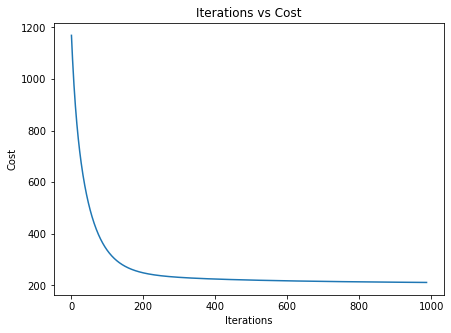

In [15]:
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")

seq_regressor = Regressor(normalize=True)
seq_regressor.seq_fit(X_train,y_train)

train_score = r2_score(y_train,seq_regressor.predict(X_train))
test_score = r2_score(y_test,seq_regressor.predict(X_test))

print("Train Score:", train_score)
print("Test Score: ",test_score)
seq_regressor.plot()

## 7.4 Plotting the data and the regressor

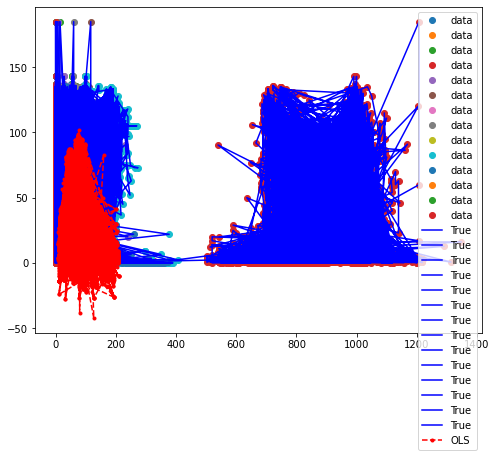

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(X, y, "o", label="data")
ax.plot(X, y, "b-", label="True")
ax.plot(X_train[:, 0], seq_regressor.predict(X_train), "r--.", label="OLS")
ax.legend(loc="best")

# 8. Implementing Sequential Gradient Descent using sklearn

## 8.1 Implementing SGD

In [108]:
from sklearn.linear_model import SGDRegressor, Ridge,ElasticNet,Lasso
SGD_Regressor = SGDRegressor()
SGD_Regressor.fit(X_train,y_train)
y_p = SGD_Regressor.predict(X_test)
sgd_coefficient = pd.DataFrame()
sgd_coefficient["Columns"] = df_c.columns # for getting column names
sgd_coefficient['Coefficient Estimate'] = pd.DataFrame(SGD_Regressor.coef_)
sgd_coeff = sgd_coefficient.set_index('Columns')
print(sgd_coeff)
print("R2 Score =",r2_score(y_test,y_p))

                                 Coefficient Estimate
Columns                                              
wtd_mean_atomic_mass                     1.273164e+11
wtd_entropy_atomic_mass                  3.825199e+10
wtd_std_atomic_mass                     -1.119290e+11
wtd_mean_fie                            -4.729064e+10
wtd_range_atomic_radius                  4.023643e+09
wtd_mean_ElectronAffinity                1.938587e+11
wtd_entropy_ElectronAffinity            -3.526704e+10
wtd_std_ElectronAffinity                 8.467363e+10
wtd_mean_FusionHeat                      5.015692e+10
wtd_mean_ThermalConductivity            -8.937411e+10
wtd_gmean_ThermalConductivity            1.037190e+11
wtd_entropy_ThermalConductivity          1.681675e+11
wtd_std_Valence                         -3.921789e+10
R2 Score = -3.943154701196106e+23


## 8.2  Implementing LASSO

In [75]:
lasso = Lasso(alpha=0.8)
lasso.fit(X_train, y_train)

Lasso(alpha=0.8)

## 8.3 Calculate Mean Squared Error

In [76]:
# Training data
pred_train = lasso.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set',mse_train)

# Test data
pred = lasso.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set',mse_test)

MSE training set 448.64022669539935
MSE test set 466.01888024885574


## 8.4 Calculating Coefficient Estimate

In [86]:
lasso_coefficient = pd.DataFrame()
lasso_coefficient["Columns"] = df_c.columns # for getting column names
lasso_coefficient['Coefficient Estimate'] = pd.DataFrame(lasso.coef_)
lasso_coeff = lasso_coefficient.set_index('Columns')
print(lasso_coeff)

                                 Coefficient Estimate
Columns                                              
wtd_mean_atomic_mass                        -0.016063
wtd_entropy_atomic_mass                      0.468749
wtd_std_atomic_mass                          0.107276
wtd_mean_fie                                 0.043019
wtd_range_atomic_radius                     -0.034850
wtd_mean_ElectronAffinity                   -0.224605
wtd_entropy_ElectronAffinity                -0.000000
wtd_std_ElectronAffinity                     0.115307
wtd_mean_FusionHeat                         -0.034309
wtd_mean_ThermalConductivity                 0.498808
wtd_gmean_ThermalConductivity               -0.485286
wtd_entropy_ThermalConductivity              2.868337
wtd_std_Valence                             -7.408096


## 8.5 Calculating R squared values

In [102]:
print('Accuracy of training set', lasso.score(X_train, y_train))
print('Accuracy of set', lasso.score(X_test, y_test))

Accuracy of training set 0.6091383677308051
Accuracy of set 0.5996641405170282


## 8.6 Implementing Ridge

In [88]:
# Train the model
ridgeR = Ridge(alpha = 0.8)
ridgeR.fit(X_train, y_train)
y_pred = ridgeR.predict(X_test)

# calculate mean square error
mean_squared_error_ridge = np.mean((y_pred - y_test)**2)
print('MSE =',mean_squared_error_ridge)

# get ridge coefficient and print them
ridge_coefficient = pd.DataFrame()
ridge_coefficient["Columns"]= df_c.columns
ridge_coefficient['Coefficient Estimate'] = pd.DataFrame(ridgeR.coef_)
ridge_coeff = ridge_coefficient.set_index('Columns')
print(ridge_coeff)

MSE = 419.2101073342187
                                 Coefficient Estimate
Columns                                              
wtd_mean_atomic_mass                         0.007662
wtd_entropy_atomic_mass                     16.746463
wtd_std_atomic_mass                          0.159270
wtd_mean_fie                                 0.029340
wtd_range_atomic_radius                      0.008587
wtd_mean_ElectronAffinity                   -0.173578
wtd_entropy_ElectronAffinity               -23.037731
wtd_std_ElectronAffinity                     0.077133
wtd_mean_FusionHeat                         -0.009426
wtd_mean_ThermalConductivity                 0.497197
wtd_gmean_ThermalConductivity               -0.505175
wtd_entropy_ThermalConductivity             18.059808
wtd_std_Valence                            -11.819181


In [101]:
print('Accuracy of training set', ridgeR.score(X_train, y_train))
print('Accuracy of test set', ridgeR.score(X_test, y_test))

Accuracy of training set 0.6507528338821016
Accuracy of test set 0.6473209505616128


## 8.7 Elastic Net

In [89]:
# Train the model
e_net = ElasticNet(alpha = 0.8)
e_net.fit(X_train, y_train)

# calculate the prediction and mean square error
y_pred_elastic = e_net.predict(X_test)
mean_squared_error = np.mean((y_pred_elastic - y_test)**2)
print("Mean Squared Error on test set", mean_squared_error)

e_net_coefficient = pd.DataFrame()
e_net_coefficient["Columns"] = df_c.columns
e_net_coefficient['Coefficient Estimate'] = pd.Series(e_net.coef_)
e_net_coeff = e_net_coefficient.set_index('Columns')
e_net_coeff

Mean Squared Error on test set 478.3391027751569


,Coefficient Estimate
Columns,
wtd_mean_atomic_mass,-0.012787
wtd_entropy_atomic_mass,1.048493
wtd_std_atomic_mass,0.088834
wtd_mean_fie,0.046517
wtd_range_atomic_radius,-0.028403
wtd_mean_ElectronAffinity,-0.228830
wtd_entropy_ElectronAffinity,-0.349968
wtd_std_ElectronAffinity,0.078407
wtd_mean_FusionHeat,-0.026642


In [103]:
print('Accuracy of training set', e_net.score(X_train, y_train))
print('Accuracy of test set', e_net.score(X_test, y_test))

Accuracy of training set 0.6063905407734923
Accuracy of test set 0.5975760671689727


# 9. Plotting

## 9.1 Ploting lasso coefficients as a function of alpha

C:\Users\Ujjwa\AppData\Local\Temp/ipykernel_7772/1582538340.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train, y_train)
C:\Users\Ujjwa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ujjwa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.915e+06, tolerance: 2.242e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


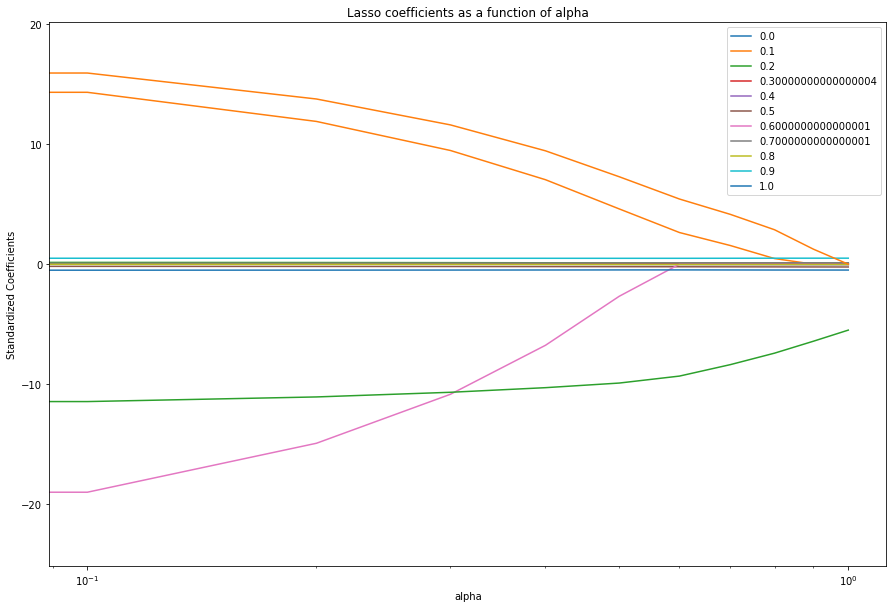

In [90]:
alphas = np.arange(0,1.1,0.1)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(15, 10))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')
plt.legend(alphas)

## 9.2 Comparision of OLS and LASSO

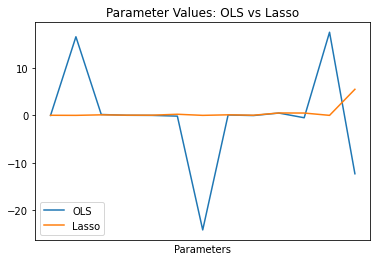

In [91]:
plt.plot(OLS_Coff)
plt.plot(np.abs(lasso.coef_))
plt.xticks("")
plt.xlabel("Parameters")
plt.legend(["OLS","Lasso"])
plt.title("Parameter Values: OLS vs Lasso")
plt.show()

## 9.3 Comparision of OLS and Ridge

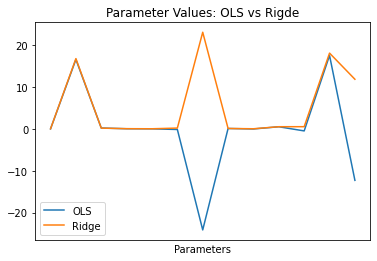

In [92]:
plt.plot(OLS_Coff)
plt.plot(np.abs(ridgeR.coef_))
plt.xticks("")
plt.xlabel("Parameters")
plt.legend(["OLS","Ridge"])
plt.title("Parameter Values: OLS vs Rigde")
plt.show()

## 9.4 Comparision of Lasso and Ridge

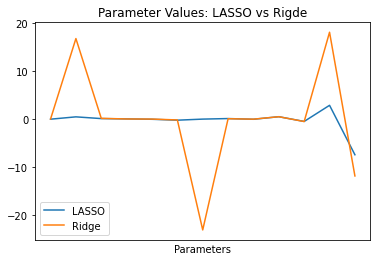

In [93]:
plt.plot(lasso_coeff)
plt.plot(ridge_coeff)
plt.xticks("")
plt.xlabel("Parameters")
plt.legend(["LASSO","Ridge"])
plt.title("Parameter Values: LASSO vs Rigde")
plt.show()

## 9.5 Comparision of Lasso and Ridge and Elastic Net

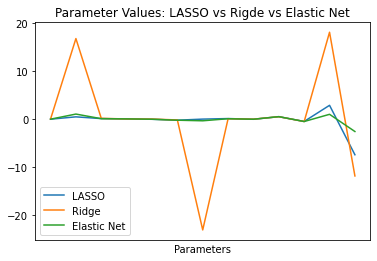

In [94]:
plt.plot(lasso_coeff)
plt.plot(ridge_coeff)
plt.plot(e_net_coeff)
plt.xticks("")
plt.xlabel("Parameters")
plt.legend(["LASSO","Ridge","Elastic Net"])
plt.title("Parameter Values: LASSO vs Rigde vs Elastic Net")
plt.show()

## 9.6 Comparision of OLS ,LASSO, Ridge and Elastic Net

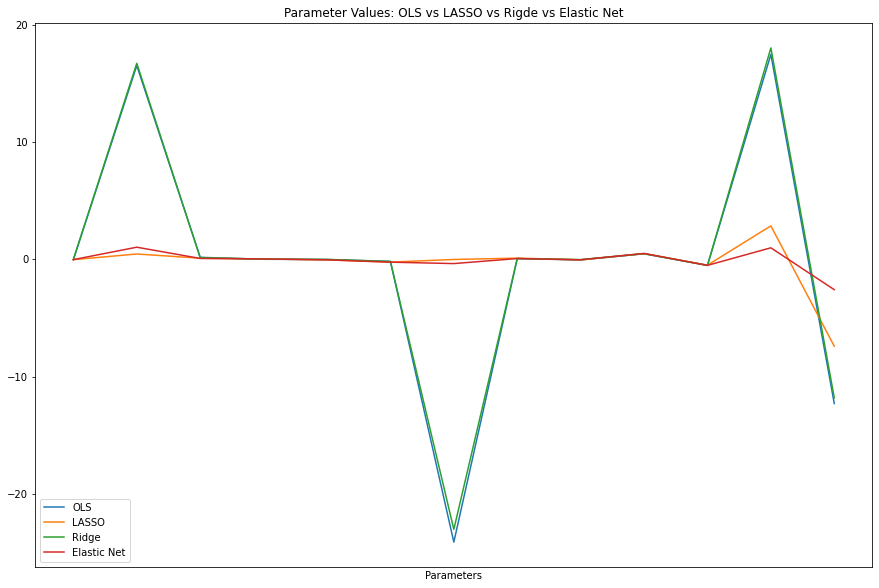

In [95]:
plt.figure(figsize=(15, 10))
plt.plot(OLS_Coff)
plt.plot(lasso_coeff)
plt.plot(ridge_coeff)
plt.plot(e_net_coeff)
plt.xticks("")
plt.xlabel("Parameters")
plt.legend(["OLS","LASSO","Ridge","Elastic Net"])
plt.title("Parameter Values: OLS vs LASSO vs Rigde vs Elastic Net")
plt.show()

## 9.7 Comparision of LASSO and Elastic Net

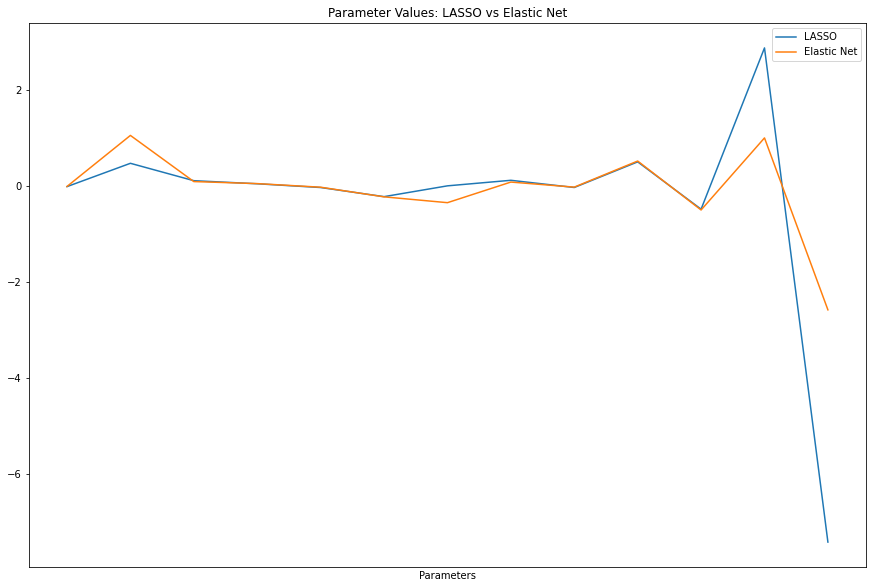

In [96]:
plt.figure(figsize=(15, 10))
plt.plot(lasso_coeff)
plt.plot(e_net_coeff)
plt.xticks("")
plt.xlabel("Parameters")
plt.legend(["LASSO","Elastic Net"])
plt.title("Parameter Values: LASSO vs Elastic Net")
plt.show()

# 10. Paths

## 10.1 LASSO LARS Paths

.

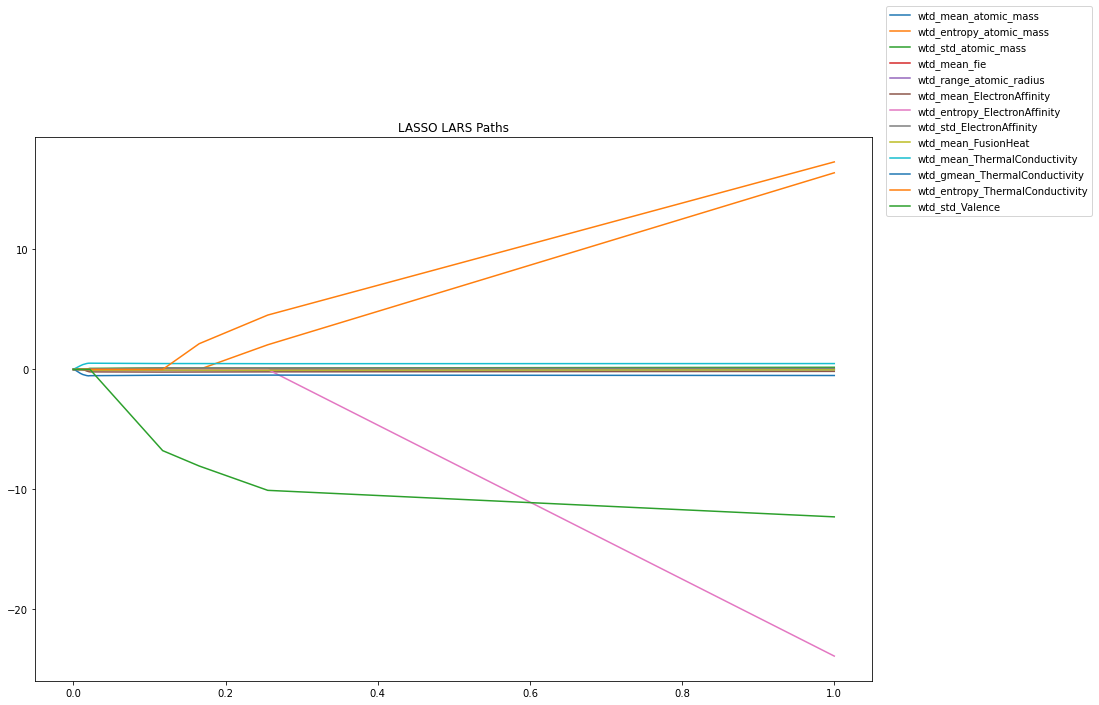

In [97]:
_,_,coefs = lars_path(np.array(X_train), np.array(y_train),method = "lar", verbose=True)

xx = np.sum(np.abs(np.matrix(coefs.T)), axis=1)
xx /= xx[-1]
plt.figure(figsize=(15, 10))
plt.plot(xx,coefs.T)
plt.title("LASSO LARS Paths")
plt.legend(df_c.columns,loc = "best",bbox_to_anchor =(1.01, 1.25))
plt.show()

## 10.2 Ridge Paths

.

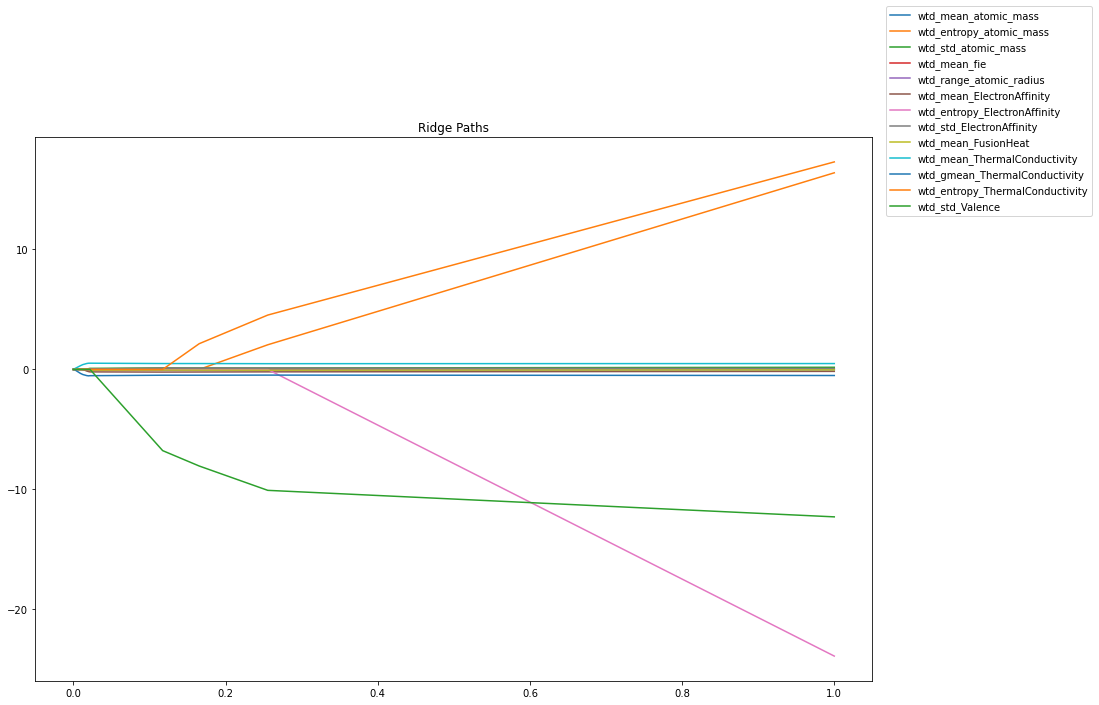

In [98]:
_,_,coefs = lars_path(np.array(X_train), np.array(y_train),method = "Ridge", verbose=True)

xx = np.sum(np.abs(np.matrix(coefs.T)), axis=1)
xx /= xx[-1]

plt.figure(figsize=(15, 10))
plt.plot(xx,coefs.T)
plt.title("Ridge Paths")
plt.legend(df_c.columns,loc = "best",bbox_to_anchor =(1.01, 1.25))
plt.show()